# CASA0002_Urban simulation Assignment

<div style="float:left">
            <h1 style="width:450px">Code Part 1</h1>
</div>
<div style="float:right"><img width="100" src="https://github.com/jreades/i2p/raw/master/img/casa_logo.jpg" /></div>


Assignment requirements [here](https://github.com/yiyansun/urbsim/blob/main/assessment/AssessUrbanSim2024.pdf)

Marking scheme [here](https://github.com/yiyansun/urbsim/blob/main/assessment/UrbanSim_Marking_Scheme.pdf)

Code is available [here](https://github.com/yiyansun/urbsim/blob/main/assessment/Part1.ipynb)

[Data](https://github.com/yiyansun/urbsim/tree/main/assessment/data) : London underground graph and london_flow.csv

In [1]:
import requests
import urllib.request
import io

import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import heapq
import json
import re
from shapely.geometry import Point, LineString #this library is for manipulating geometric objects, and it is what geopandas uses to store geometries
from scipy.spatial import distance

C:\Users\dune\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Part 1: London’s underground resilience

## 1. Topological network

> understand the vulnerability of the London Underground network to random failures and targeted attacks. The London Underground network is a complex system of interconnected stations and lines. The network is represented as a graph, where stations are nodes and connections between stations are edges. The graph is undirected and unweighted, meaning that connections between stations are bidirectional and do not have associated travel times. The graph is also connected, meaning that there is a path between any two stations in the network. 34 marks

> Evaluate the resilience of the London’s underground through the removal of 
stations that can potentially make the underground vulnerable. Through the procedure outlined below 
you will investigate which are the stations that are most critical for the functioning of the 
underground, and which methodology is more appropriate to finding these stations.

In [2]:
# read the london tube network graphml file
url = "https://github.com/yiyansun/urbsim/raw/main/assessment/data/london_tubenetwork.graphml"
with urllib.request.urlopen(url) as response:
    content = response.read().decode('utf-8')
file = io.StringIO(content)

# Read the GraphML content and create the graph
G = nx.read_graphml(file)

# Check the type of G
print(type(G))

<class 'networkx.classes.graph.Graph'>


In [3]:
london_flows = pd.read_csv('https://raw.githubusercontent.com/yiyansun/urbsim/main/assessment/data/london_flows.csv')
london_flows.head()

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167


In [4]:
# Get the number of nodes and edges in the Tube network
num_nodes_tube = G.number_of_nodes()
num_edges_tube = G.number_of_edges()

print("Number of nodes in the tube network:", G.number_of_nodes())
print("Number of edges in the tube network:", G.number_of_edges())

Number of nodes in the tube network: 438
Number of edges in the tube network: 486


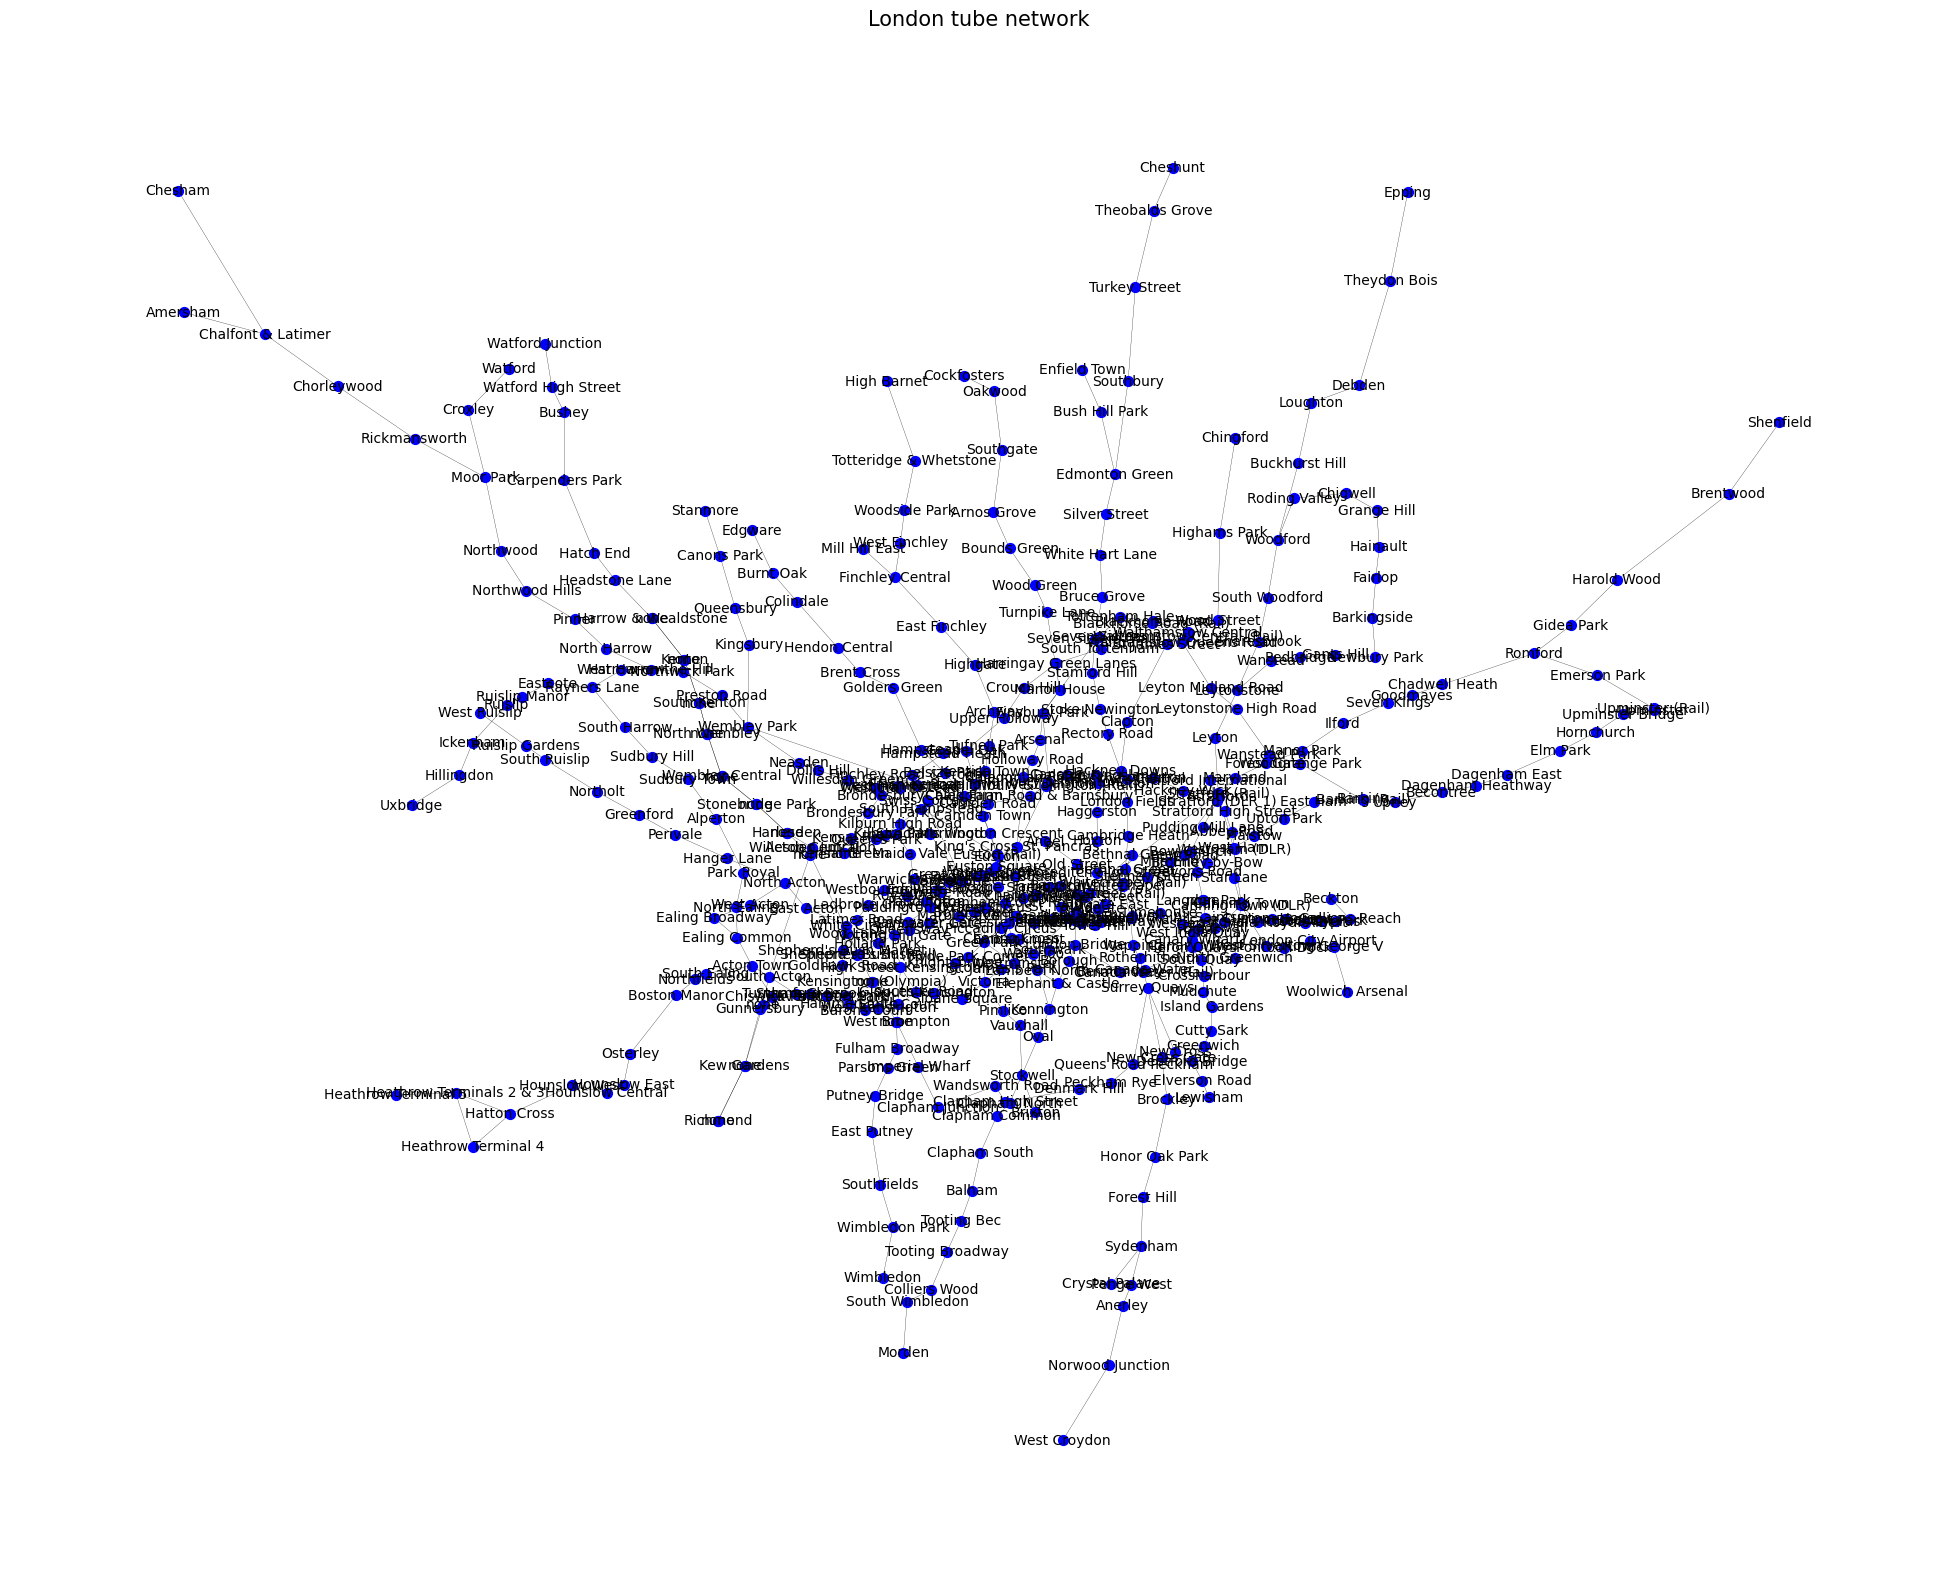

In [5]:
# since coords tuples are stored as string, need to convert them back to tuples using eval()
for node in G.nodes():
    G.nodes[node]['coords'] = eval(G.nodes[node]['coords'])
    
# add the stations name to the edge attributes from the nodes attributes:

nod_name1={(e1,e2):(G.nodes[e1]['station_name']) for e1, e2 in G.edges()}
nod_name2={(e1,e2):(G.nodes[e2]['station_name']) for e1, e2 in G.edges()}

nx.set_edge_attributes(G,nod_name1,'station_1_')
nx.set_edge_attributes(G,nod_name2,'station_2_')

# plot the tube network with the names of the stations as labels
fig, ax = plt.subplots(figsize=(25,20))

node_labels = nx.get_node_attributes(G, 'station_name')

pos = nx.get_node_attributes(G, 'coords')

nx.draw_networkx_nodes(G,pos,node_size=50,node_color='b')
nx.draw_networkx_edges(G,pos,arrows=False,width=0.2)
nx.draw_networkx_labels(G,pos, node_labels, font_size=10, font_color='black')

plt.title("London tube network",fontsize=15)
plt.axis("off")
plt.show()

### 1.1 Centrality measures:

> Select 3 centrality measures to characterise nodes, aiming at identifying the most important nodes in 
the underground network. Give the definition of each of the measures (including their equation), put 
the measures into the context of the underground, and why they will allow you to find the stations that 
are most crucial for the functioning of the underground. Compute the measures for your nodes in the 
network, and give the results in a table for the first 10 ranked nodes for each of the 3 measures.

> 6 (2 per measure)


Here we choose
- Degree centrality
- Closeness centrality
- Betweeness centrality  

#### 1.1.1 Degree centrality

In [6]:
degree=nx.degree_centrality(G)
nx.set_node_attributes(G,dict(degree),'degree')

# To dataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())
df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df['degree'] = pd.Series(nx.get_node_attributes(G, 'degree'))

# Sort DataFrame by degree centrality in descending order and display top 10
df_sorted = df.sort_values(["degree"], ascending=False)
degree_centrality = df_sorted[0:10]
degree_centrality

,station_name,degree
940GZZLUKSX,King's Cross St. Pancras,0.016018
940GZZLUBST,Baker Street,0.016018
940GZZLUOXC,Oxford Circus,0.013730
940GZZLUGPK,Green Park,0.013730
940GZZLUBNK,Bank,0.013730
940GZZLUECT,Earl's Court,0.013730
940GZZLUWLO,Waterloo,0.013730
940GZZLUTNG,Turnham Green,0.011442
940GZZDLCGT,Canning Town (DLR),0.011442
940GZZLULVT,Liverpool Street,0.011442


In [7]:
degree_centrality = pd.DataFrame(nx.degree(G), columns=['degree(nonseq)', 'value']) \
                      .sort_values(by='value', ascending=False) \
                      .iloc[:10]
degree_centrality

,degree(nonseq),value
38,940GZZLUKSX,7
145,940GZZLUBST,7
35,940GZZLUOXC,6
34,940GZZLUGPK,6
196,940GZZLUBNK,6
45,940GZZLUECT,6
281,940GZZLUWLO,6
50,940GZZLUTNG,5
229,940GZZDLCGT,5
126,940GZZLULVT,5


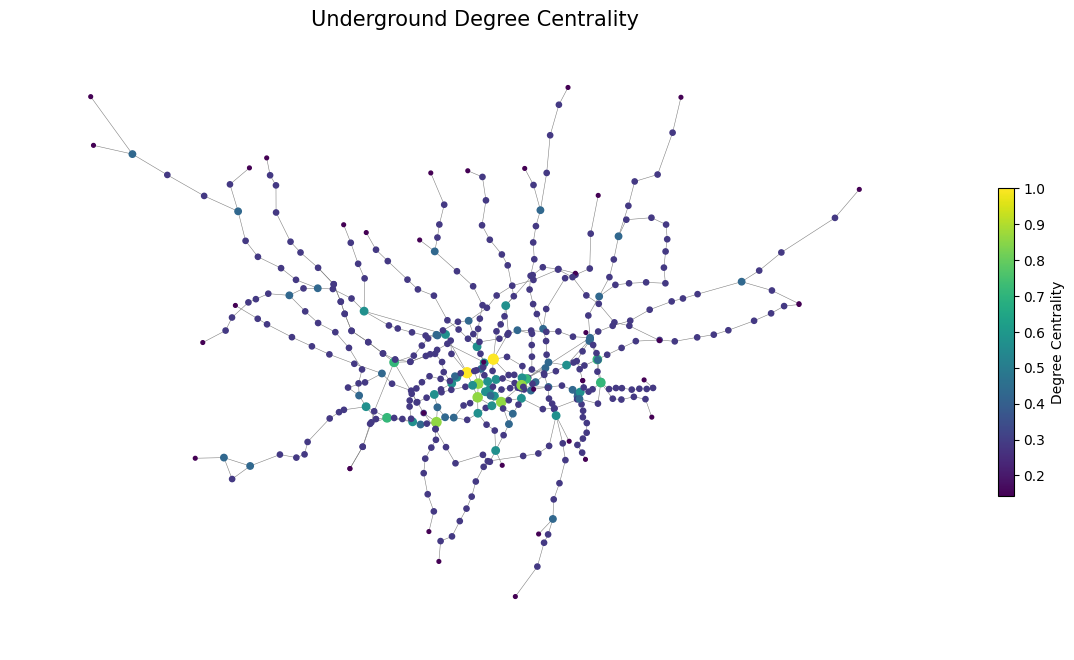

In [8]:

degree_values=[(i[1]['degree']) for i in G.nodes(data=True)]

deg_color=[(i[1]['degree']/(max(degree_values))) for i in G.nodes(data=True)]
deg_size=[(i[1]['degree']/(max(degree_values)))*50 for i in G.nodes(data=True)]

pos=pos

fig, ax = plt.subplots(figsize=(15,8))

nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= deg_color,
        node_size= deg_size)

plt.colorbar(nod,label="Degree Centrality",orientation="vertical", shrink=0.5)
plt.axis("off")
plt.title("Underground Degree Centrality",fontsize=15)
plt.savefig("output/degree_centrality.png", format="PNG")
plt.show()

#### 1.1.2 Betweenness centrality

**Definition:** Betweenness centrality quantifies the significance of a node based on how often it serves as a bridge or intermediary along the shortest paths between other nodes in the network. This measure underscores nodes that, although they might not be highly connected themselves, play a crucial role in controlling the flow of information through the network.


betweenness centrality on nodes

In [9]:
bet_t=nx.betweenness_centrality(G,normalized=True,weight='length')

# add these values to the nodes attributes:
nx.set_node_attributes(G,bet_t,'betweenness')
# To dataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())
df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df['betweenness'] = pd.Series(nx.get_node_attributes(G, 'betweenness'))

df_sorted = df.sort_values(["betweenness"], ascending=False)
betweenness_centrality = df_sorted[0:10]
betweenness_centrality

,station_name,betweenness
940GZZLUBST,Baker Street,0.385594
940GZZLUFYR,Finchley Road,0.312661
940GZZLULVT,Liverpool Street,0.270317
910GWHMDSTD,West Hampstead,0.270264
940GZZLUWHP,West Hampstead,0.269624
940GZZLUKSX,King's Cross St. Pancras,0.258518
940GZZLUBNK,Bank,0.221349
940GZZLUMED,Mile End,0.186415
940GZZLUOXC,Oxford Circus,0.181775
910GBTHNLGR,Bethnal Green,0.180663


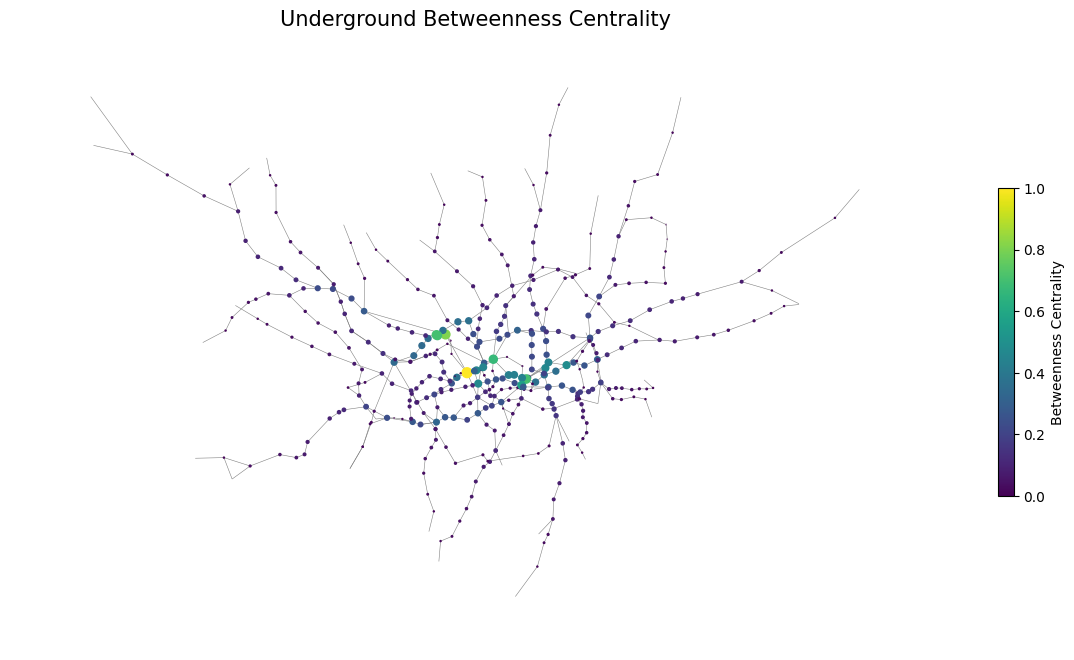

In [10]:
# plot 
bet_values=[(i[1]['betweenness']) for i in G.nodes(data=True)]

bet_color=[(i[1]['betweenness']/(max(bet_values))) for i in G.nodes(data=True)]
bet_size=[(i[1]['betweenness']/(max(bet_values)))*50 for i in G.nodes(data=True)]

pos=pos

fig, ax = plt.subplots(figsize=(15,8))

nx.draw_networkx_edges(G, pos,edge_color='gray',
        width=0.4)
nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= bet_color,
        node_size= bet_size)

plt.colorbar(nod,label="Betweenness Centrality",orientation="vertical", shrink=0.5)
plt.axis("off")
plt.title("Underground Betweenness Centrality",fontsize=15)
plt.savefig("output/betweenness_centrality.png", format="PNG")
plt.show()

#### 1.1.3 Closeness centrality

**Definition:** Closeness centrality measures the reciprocal of the mean geodesic distance (shortest path) from a given node to all other nodes in the network. A node that is closer to most other nodes and has a low mean geodesic distance is deemed to be more central, indicating that it can reach other nodes more quickly than those with higher mean geodesic distances.


In [11]:
#Weighted closeness centrality: 
clos_t=nx.closeness_centrality(G)
# add these values to the nodes attributes:
nx.set_node_attributes(G,clos_t,'closeness')

# To dataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())
df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df['closeness'] = pd.Series(nx.get_node_attributes(G, 'closeness'))

df_sorted = df.sort_values(["closeness"], ascending=False)
closeness_centrality = df_sorted[0:10]
closeness_centrality

,station_name,closeness
940GZZLUGPK,Green Park,0.094897
940GZZLUBND,Bond Street,0.093737
940GZZLUWSM,Westminster,0.093197
940GZZLUBST,Baker Street,0.092900
940GZZLUWLO,Waterloo,0.092389
940GZZLUBNK,Bank,0.092000
940GZZLUOXC,Oxford Circus,0.091614
940GZZLULVT,Liverpool Street,0.090010
940GZZLURGP,Regent's Park,0.089275
940GZZLUFYR,Finchley Road,0.089165


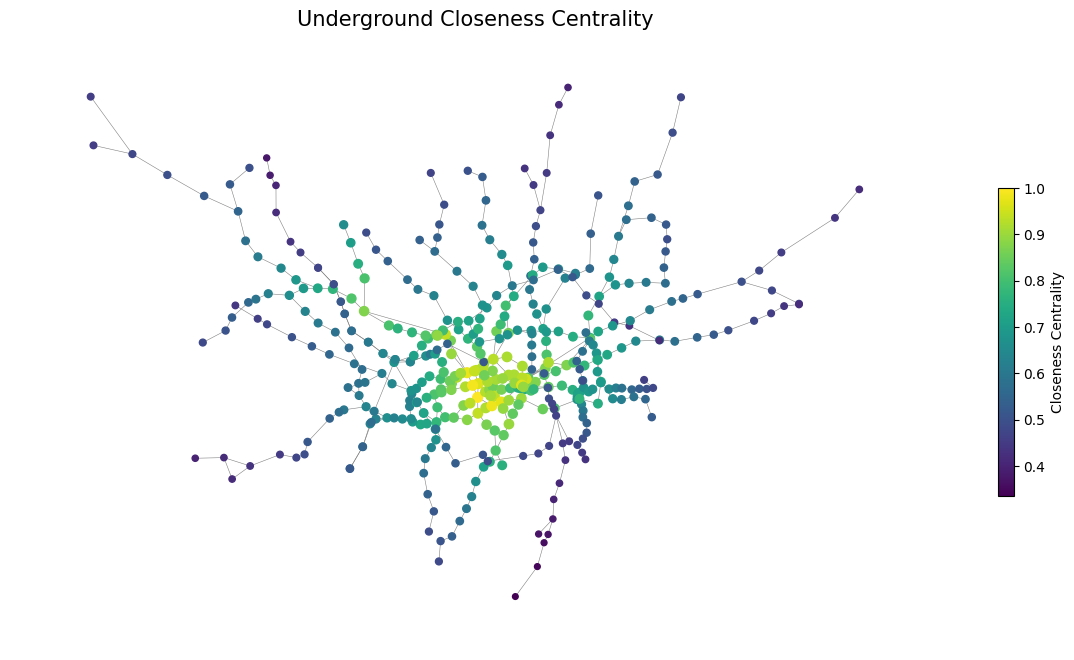

In [12]:
# plot 
clos_values=[(i[1]['closeness']) for i in G.nodes(data=True)]

clos_color=[(i[1]['closeness']/(max(clos_values))) for i in G.nodes(data=True)]
clos_size=[(i[1]['closeness']/(max(clos_values)))*50 for i in G.nodes(data=True)]

pos=pos

fig, ax = plt.subplots(figsize=(15,8))

nx.draw_networkx_edges(G, pos,edge_color='gray',
        width=0.4)
nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= clos_color,
        node_size= clos_size)

plt.colorbar(nod,label="Closeness Centrality",orientation="vertical", shrink=0.5)
plt.axis("off")
plt.title("Underground Closeness Centrality",fontsize=15)
plt.savefig("output/closeness_centrality.png", format="PNG")
plt.show()

Merge the results of three centrality measures into one DataFrame

In [13]:
top_stations_nonseq = pd.concat([degree_centrality.reset_index(drop=True),
                                 betweenness_centrality.reset_index(drop=True),
                                 closeness_centrality.reset_index(drop=True)], axis=1)

# Add a column named "Rank" indicating the ranking of nodes across different centrality measures
top_stations_nonseq.insert(0, 'Rank', range(1, 11))

top_stations_nonseq

,Rank,degree(nonseq),value,station_name,betweenness,station_name,closeness
0,1,940GZZLUKSX,7,Baker Street,0.385594,Green Park,0.094897
1,2,940GZZLUBST,7,Finchley Road,0.312661,Bond Street,0.093737
2,3,940GZZLUOXC,6,Liverpool Street,0.270317,Westminster,0.093197
3,4,940GZZLUGPK,6,West Hampstead,0.270264,Baker Street,0.092900
4,5,940GZZLUBNK,6,West Hampstead,0.269624,Waterloo,0.092389
5,6,940GZZLUECT,6,King's Cross St. Pancras,0.258518,Bank,0.092000
6,7,940GZZLUWLO,6,Bank,0.221349,Oxford Circus,0.091614
7,8,940GZZLUTNG,5,Mile End,0.186415,Liverpool Street,0.090010
8,9,940GZZDLCGT,5,Oxford Circus,0.181775,Regent's Park,0.089275
9,10,940GZZLULVT,5,Bethnal Green,0.180663,Finchley Road,0.089165


### 1.2 Impact measures:

> Find 2 different measures to evaluate the impact of the node removal on the network. These need to 
be global measures referring to the whole network and not to specific nodes or links. Explain whether 
these two measures are specific to the London underground, or whether they could also be used to 
evaluate the resilience of any other network.

> 8 (4 per measure)

#### 1.2.1 Average degree

**Definition:** The average degree of a network is the mean value of the degrees of all nodes in the network. 

\begin{equation}
\text{Average Degree} = \frac{\sum_{i} D_i}{n}
\end{equation}

Where \(D\) is the degree of each node, \(n\) is the total number of nodes in the network.

#### 1.2.2 Global efficiency

**Definition:** Global efficiency is a measure that quantifies the efficiency of information or traffic exchange over a network. It's the average of the inverse shortest path length between every pair of nodes. Mathematically:

\begin{equation}
\text{Global Efficiency} = \frac{1}{n(n-1)} \sum_{i \neq j} \frac{1}{d_{ij}}
\end{equation}

Where \(d_{ij}\) is the shortest path distance between nodes \(i\) and \(j\), and \(n\) is the total number of nodes.

### 1.3. Node removal

> For each of the centrality measures selected in I.1. remove at least 10 nodes following two different 
strategies.   20

>> A) Non-sequential removal: using the table created in I.1. remove 1 node at a time 
following the rank in the table, i.e. from the most important one to the 10th most important one. After 
each removal, evaluate the impact of the removal using your two measures in I.2. and proceed until 
you have removed at least 10 nodes. 

>> B) Sequential: remove the highest ranked node and evaluate the 
impact using the 2 measures. After removal, re-compute the centrality measure. Remove the highest 
ranked node in the new network and evaluate the impact. Continue until removing at least 10 nodes.

> Report the results of the 2 strategies in one plot, and critically discuss the following: which centrality 
measure reflects better the importance of a station for the functioning of the underground, which 
strategy is more effective at studying resilience, and which impact measure is better at assessing the 
damage after node removal

#### 1.3.1 non-sequential removal

In [14]:
top_stations_nonseq

,Rank,degree(nonseq),value,station_name,betweenness,station_name,closeness
0,1,940GZZLUKSX,7,Baker Street,0.385594,Green Park,0.094897
1,2,940GZZLUBST,7,Finchley Road,0.312661,Bond Street,0.093737
2,3,940GZZLUOXC,6,Liverpool Street,0.270317,Westminster,0.093197
3,4,940GZZLUGPK,6,West Hampstead,0.270264,Baker Street,0.092900
4,5,940GZZLUBNK,6,West Hampstead,0.269624,Waterloo,0.092389
5,6,940GZZLUECT,6,King's Cross St. Pancras,0.258518,Bank,0.092000
6,7,940GZZLUWLO,6,Bank,0.221349,Oxford Circus,0.091614
7,8,940GZZLUTNG,5,Mile End,0.186415,Liverpool Street,0.090010
8,9,940GZZDLCGT,5,Oxford Circus,0.181775,Regent's Park,0.089275
9,10,940GZZLULVT,5,Bethnal Green,0.180663,Finchley Road,0.089165


#### 1.3.2 sequential removal

In [15]:
degree_centrality_seq = []
station_names = []

# Create a copy of the original graph G to avoid modifying it directly.
G_dc_seq = G.copy()

for i in range(10):
    degree = nx.degree(G_dc_seq)
    nx.set_node_attributes(G_dc_seq, dict(degree), 'degree')
    
    degree_df = pd.DataFrame.from_dict(dict(degree), columns=['degree'], orient='index')
    node = degree_df.sort_values('degree', ascending=False).index[0] # Find the node with the highest degree centrality.
    station_name = G_dc_seq.nodes[node]['station_name'] 
    station_names.append(station_name)
    
    degree_centrality_seq.append(station_name)
    G_dc_seq.remove_node(node)

degree_centrality_seq


["King's Cross St. Pancras",
 'Baker Street',
 'Waterloo',
 'Green Park',
 "Earl's Court",
 'Canning Town (DLR)',
 'Oxford Circus',
 'Liverpool Street',
 'Turnham Green',
 'none']

In [16]:
betweenness_centrality_seq = []
G_bc_seq = G.copy()

for i in range(10):
    betweenness = nx.betweenness_centrality(G_bc_seq, normalized=True, weight='length')
    nx.set_node_attributes(G_bc_seq, betweenness, 'betweenness')
    
    betweenness_df = pd.DataFrame.from_dict(betweenness, columns=['betweenness'], orient='index')
    node = betweenness_df.sort_values('betweenness', ascending=False).index[0] # Find the node with the highest betweenness centrality.
    station_name = G_bc_seq.nodes[node]['station_name'] 
    
    betweenness_centrality_seq.append(station_name)
    G_bc_seq.remove_node(node)
    
betweenness_centrality_seq

['Baker Street',
 'Bethnal Green',
 "Earl's Court",
 'Notting Hill Gate',
 'West Hampstead',
 'Bank',
 'Mile End',
 'Canary Wharf',
 'Canning Town',
 'Ealing Common']

In [17]:
closeness_centrality_seq = []
station_names = []

G_cc_seq = G.copy()

for i in range(10):
    closeness = nx.closeness_centrality(G_cc_seq)
    nx.set_node_attributes(G_cc_seq, closeness, 'closeness')
    
    closeness_df = pd.DataFrame.from_dict(closeness, columns=['closeness'], orient='index')
    node = closeness_df.sort_values('closeness', ascending=False).index[0] # Find the node with the highest closeness centrality.
    station_name = G_cc_seq.nodes[node]['station_name'] 
    station_names.append(station_name)
    
    closeness_centrality_seq.append(station_name)
    G_cc_seq.remove_node(node)

closeness_centrality_seq

['Green Park',
 'Baker Street',
 'Liverpool Street',
 'Canary Wharf',
 'Embankment',
 'Canning Town (DLR)',
 'Harrow-on-the-Hill',
 'High Street Kensington',
 'Bank',
 'Stratford (Rail)']

reassamble the results of node removal into one DataFrame

In [18]:
top_stations_seq= pd.DataFrame({'degree(seq)': degree_centrality_seq, 'closeness(seq)': closeness_centrality_seq, 'betweenness(seq)': betweenness_centrality_seq})
top_stations_seq .insert(0,'Rank',range(1,11))
top_stations_seq

,Rank,degree(seq),closeness(seq),betweenness(seq)
0,1,King's Cross St. Pancras,Green Park,Baker Street
1,2,Baker Street,Baker Street,Bethnal Green
2,3,Waterloo,Liverpool Street,Earl's Court
3,4,Green Park,Canary Wharf,Notting Hill Gate
4,5,Earl's Court,Embankment,West Hampstead
5,6,Canning Town (DLR),Canning Town (DLR),Bank
6,7,Oxford Circus,Harrow-on-the-Hill,Mile End
7,8,Liverpool Street,High Street Kensington,Canary Wharf
8,9,Turnham Green,Bank,Canning Town
9,10,none,Stratford (Rail),Ealing Common


In [19]:
top_staions = pd.merge(top_stations_nonseq, top_stations_seq, on='Rank')
top_staions

,Rank,degree(nonseq),value,station_name,betweenness,station_name,closeness,degree(seq),closeness(seq),betweenness(seq)
0,1,940GZZLUKSX,7,Baker Street,0.385594,Green Park,0.094897,King's Cross St. Pancras,Green Park,Baker Street
1,2,940GZZLUBST,7,Finchley Road,0.312661,Bond Street,0.093737,Baker Street,Baker Street,Bethnal Green
2,3,940GZZLUOXC,6,Liverpool Street,0.270317,Westminster,0.093197,Waterloo,Liverpool Street,Earl's Court
3,4,940GZZLUGPK,6,West Hampstead,0.270264,Baker Street,0.092900,Green Park,Canary Wharf,Notting Hill Gate
4,5,940GZZLUBNK,6,West Hampstead,0.269624,Waterloo,0.092389,Earl's Court,Embankment,West Hampstead
5,6,940GZZLUECT,6,King's Cross St. Pancras,0.258518,Bank,0.092000,Canning Town (DLR),Canning Town (DLR),Bank
6,7,940GZZLUWLO,6,Bank,0.221349,Oxford Circus,0.091614,Oxford Circus,Harrow-on-the-Hill,Mile End
7,8,940GZZLUTNG,5,Mile End,0.186415,Liverpool Street,0.090010,Liverpool Street,High Street Kensington,Canary Wharf
8,9,940GZZDLCGT,5,Oxford Circus,0.181775,Regent's Park,0.089275,Turnham Green,Bank,Canning Town
9,10,940GZZLULVT,5,Bethnal Green,0.180663,Finchley Road,0.089165,none,Stratford (Rail),Ealing Common


Output rank table

In [20]:
top_stations_nonseq.to_csv('output/top_stations_nonseq.csv', index=False)
top_stations_seq.to_csv('output/top_stations_seq.csv', index=False)
top_staions.to_csv('output/top_stations.csv', index=False)

#### 1.3.3 Analysis

In [21]:
def calculate_global_efficiency(network):
    '''Calculate the global efficiency of a network.'''
    return nx.global_efficiency(network)

def calculate_average_degree(network):
    '''Calculate the average degree of a network.'''
    degrees = [degree for node, degree in network.degree()]
    return np.mean(degrees)

In [22]:
def evaluate_impact(network, nodes_to_remove):
    '''Evaluate the impact of removing nodes on the global efficiency and average degree.'''
    glob_eff_list = []
    avg_deg_list = []

    for node in nodes_to_remove:
        working_net = network.copy()
        working_net.remove_node(node)
        
        # Calculate global efficiency and average degree
        glob_eff_list.append(nx.global_efficiency(working_net))
        avg_deg_list.append(mean(dict(working_net.degree()).values()))

    return glob_eff_list, avg_deg_list


non-sequential removal

In [23]:
degree_centrality = nx.degree_centrality(G)
sorted_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)
g_1 = G.copy()

# Lists to store global efficiency and average degree after each node removal
global_dc_nonseq = []
average_dc_nonseq = []

# Iterate through nodes in sorted order
for node in sorted_nodes:
    # Remove the node from the graph
    g_1.remove_node(node)
    
    # Calculate and store global efficiency and average degree
    global_efficiency = calculate_global_efficiency(g_1)
    average_degree = calculate_average_degree(g_1)
    
    global_dc_nonseq.append(global_efficiency)
    average_dc_nonseq.append(average_degree)

print("Global Efficiency after each node removal non-sequentially:", global_dc_nonseq)
print("Average Degree after each node removal non-sequentially:", average_dc_nonseq)


Global Efficiency after each node removal non-sequentially: [0.07503193716404534, 0.06706553824995562, 0.06591023216120499, 0.064650563672556, 0.06059771679244502, 0.05683193363657537, 0.05560012049871516, 0.054277201188006725, 0.05232740719360735, 0.04617256487288586, 0.042569636218965735, 0.038441593420872194, 0.03287553943848105, 0.030529993100905685, 0.02853408753567886, 0.028391226717757224, 0.027976380979088295, 0.026501211571144725, 0.026459116058815107, 0.025592678476702945, 0.025582749653508985, 0.022432226708994443, 0.02218361760416944, 0.02220006616407999, 0.022061820356095004, 0.02192601739404223, 0.018475613257377774, 0.018513281988594418, 0.01545556243432715, 0.015509430239644299, 0.015567676183260753, 0.015374420762970699, 0.015080685453902258, 0.014814585889296206, 0.01456169584464769, 0.013211746109748934, 0.012056351345258693, 0.011813172406896633, 0.011664283882255868, 0.011058296069733334, 0.010903788653051798, 0.010946211620787493, 0.010940733931270192, 0.010983495

C:\Users\dune\AppData\Roaming\Python\Python311\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\dune\AppData\Roaming\Python\Python311\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [24]:
betweenness_centrality = nx.betweenness_centrality(G, normalized=True, weight='length')
sorted_nodes = sorted(betweenness_centrality, key=betweenness_centrality.get, reverse=True)
g_2 = G.copy()

global_bc_nonseq = []
average_bc_nonseq = []

for node in sorted_nodes:
    g_2.remove_node(node)
    global_efficiency = calculate_global_efficiency(g_2)
    average_degree = calculate_average_degree(g_2)
    global_bc_nonseq.append(global_efficiency)
    average_bc_nonseq.append(average_degree)

In [25]:
close_centrality = nx.closeness_centrality(G)
sorted_nodes = sorted(close_centrality, key=close_centrality.get, reverse=True)
g_3 = G.copy()
global_cc_nonseq = []
average_cc_nonseq = []
for node in sorted_nodes:
    g_3.remove_node(node)
    global_efficiency = calculate_global_efficiency(g_3)
    average_degree = calculate_average_degree(g_3)
    global_cc_nonseq.append(global_efficiency)
    average_cc_nonseq.append(average_degree)

In [26]:
degree=nx.degree_centrality(G)
nx.set_node_attributes(G,dict(degree),'degree')

# To dataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())
df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df['degree'] = pd.Series(nx.get_node_attributes(G, 'degree'))

# Sort DataFrame by degree centrality in descending order and display top 10
df_sorted = df.sort_values(["degree"], ascending=False)
degree_centrality = df_sorted[0:10]
degree_centrality

,station_name,degree
940GZZLUKSX,King's Cross St. Pancras,0.016018
940GZZLUBST,Baker Street,0.016018
940GZZLUOXC,Oxford Circus,0.013730
940GZZLUGPK,Green Park,0.013730
940GZZLUBNK,Bank,0.013730
940GZZLUECT,Earl's Court,0.013730
940GZZLUWLO,Waterloo,0.013730
940GZZLUTNG,Turnham Green,0.011442
940GZZDLCGT,Canning Town (DLR),0.011442
940GZZLULVT,Liverpool Street,0.011442


sequential removal

In [27]:
g_4=G.copy()
global_dc_seq=[]
average_dc_seq=[]
for i in range(0,len(list(G.nodes))):
    average_dc_seq.append(calculate_average_degree(g_4))
    global_dc_seq.append(calculate_global_efficiency(g_4))
    degree_centrality=nx.degree_centrality(g_4)
    nx.set_node_attributes(g_4,dict(degree_centrality),'degree_centrality')
    degree_df=pd.DataFrame.from_dict(dict(degree_centrality),columns=['degree_centrality'],orient='index')
    node4=list(degree_df.sort_values('degree_centrality',axis = 0,ascending = False).index)
    g_4.remove_nodes_from([node4[0]])

In [28]:
g_5=G.copy()
average_bc_seq=[]
global_bc_seq=[]
for i in range(0,len(list(G.nodes))):
    average_bc_seq.append(calculate_average_degree(g_5))
    global_bc_seq.append(calculate_global_efficiency(g_5))
    bet_london_t=nx.betweenness_centrality(g_5, normalized=True)
    nx.set_node_attributes(g_5,bet_london_t,'betweenness_centrality')
    betweenness_df=pd.DataFrame.from_dict(bet_london_t,columns=['betweenness_centrality'],orient='index')
    node5=list(betweenness_df.sort_values('betweenness_centrality',axis = 0,ascending = False).index)
    g_5.remove_nodes_from([node5[0]])

In [29]:
g_6=G.copy()
average_cc_seq=[]
global_cc_seq=[]
for i in range(0,len(list(G.nodes))):
    average_cc_seq.append(calculate_average_degree(g_6))
    global_cc_seq.append(calculate_global_efficiency(g_6))
    clos_london_t=nx.closeness_centrality(g_6)
    nx.set_node_attributes(g_6,clos_london_t,'closeness_centrality')
    closeness_df=pd.DataFrame.from_dict(clos_london_t,columns=['closeness_centrality'],orient='index')
    node6=list(closeness_df.sort_values('closeness_centrality',axis = 0,ascending = False).index)
    g_6.remove_nodes_from([node6[0]])

data normalization

In [30]:
# Normaized data
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [31]:
average_dc_nonseq_norm = NormalizeData(average_dc_nonseq[0:100])
average_bc_nonseq_norm = NormalizeData(average_bc_nonseq[0:100])
average_cc_nonseq_norm = NormalizeData(average_cc_nonseq[0:100])
average_dc_seq_norm = NormalizeData(average_dc_seq[0:100])
average_bc_seq_norm = NormalizeData(average_bc_seq[0:100])
average_cc_seq_norm = NormalizeData(average_cc_seq[0:100])

global_dc_nonseq_norm = NormalizeData(global_dc_nonseq[0:100])
global_bc_nonseq_norm = NormalizeData(global_bc_nonseq[0:100])
global_cc_nonseq_norm = NormalizeData(global_cc_nonseq[0:100])
global_dc_seq_norm = NormalizeData(global_dc_seq[0:100])
global_bc_seq_norm = NormalizeData(global_bc_seq[0:100])
global_cc_seq_norm = NormalizeData(global_cc_seq[0:100])

#### 1.3.4 Visualization

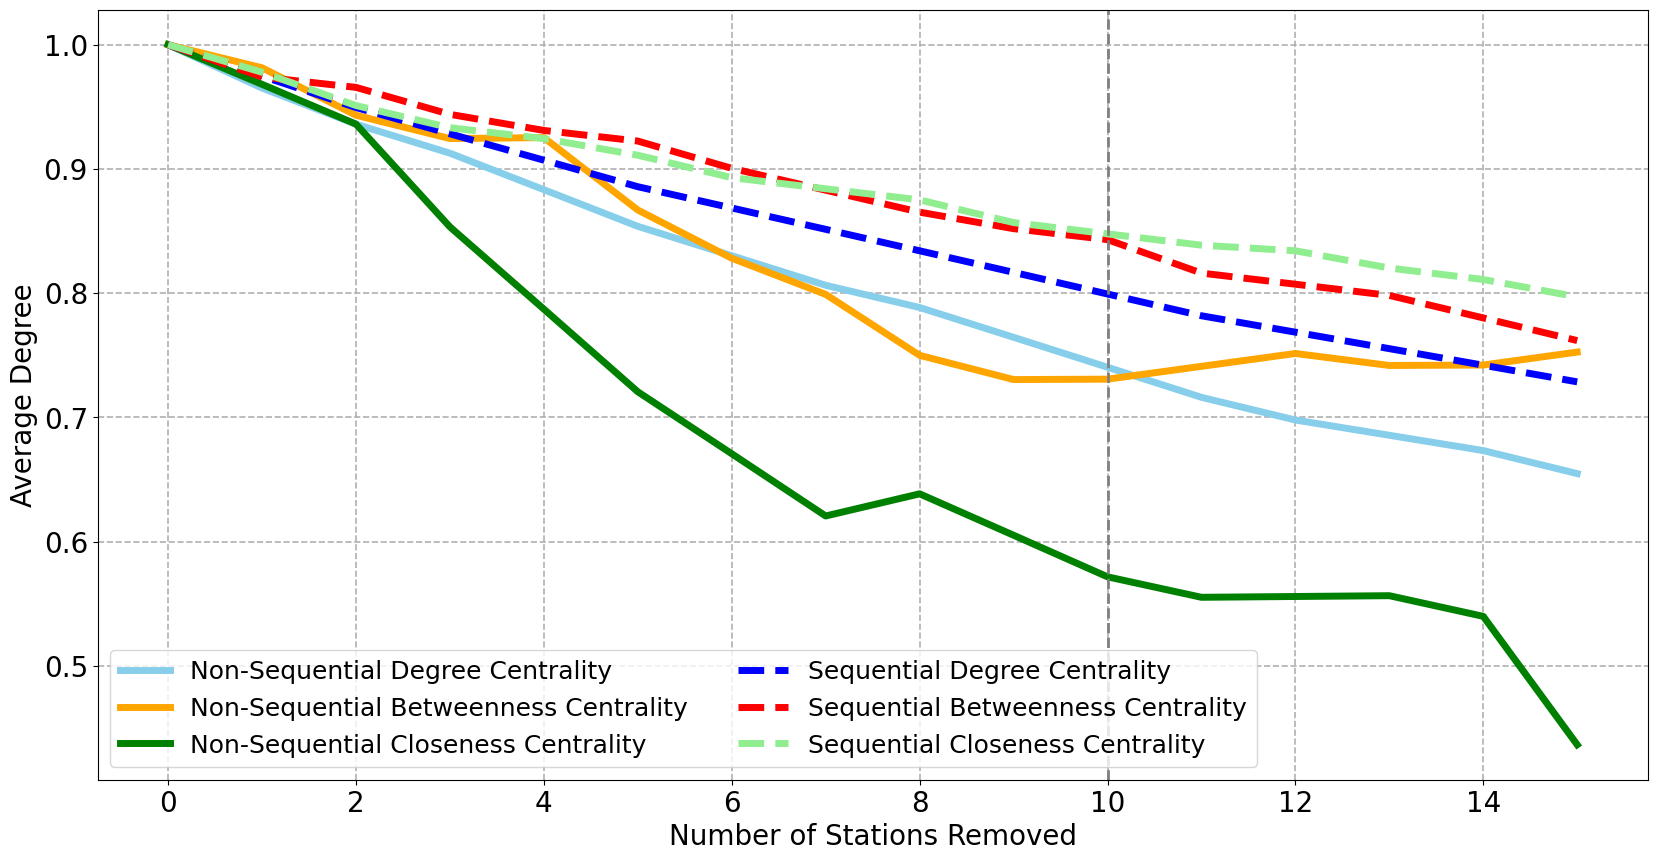

In [32]:
plt.figure(figsize=(20, 10))
plt.plot(range(16), average_dc_nonseq_norm[:16], label='Non-Sequential Degree Centrality', color='skyblue', linestyle='-',linewidth=5,markersize=12)
plt.plot(range(16), average_bc_nonseq_norm[:16], label='Non-Sequential Betweenness Centrality', color='orange', linestyle='-',linewidth=5,markersize=12)
plt.plot(range(16), average_cc_nonseq_norm[:16], label='Non-Sequential Closeness Centrality', color='green', linestyle='-',linewidth=5,markersize=12)
plt.plot(range(16), average_dc_seq_norm[:16], label='Sequential Degree Centrality', color='blue', linestyle='--',linewidth=5,markersize=12)
plt.plot(range(16), average_bc_seq_norm[:16], label='Sequential Betweenness Centrality', color='red', linestyle='--',linewidth=5,markersize=12)
plt.plot(range(16), average_cc_seq_norm[:16], label='Sequential Closeness Centrality', color='lightgreen', linestyle='--',linewidth=5,markersize=12)
plt.xlabel('Number of Stations Removed', fontsize=20)
plt.ylabel('Average Degree', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.axvline(x=10, color='grey', linestyle='--', linewidth=2)
plt.grid(True, which='both', linestyle='--', linewidth=1.2)
plt.legend(ncol=2,fontsize=18)

plt.savefig('output/average_degree1.png',dpi=300)
plt.show()


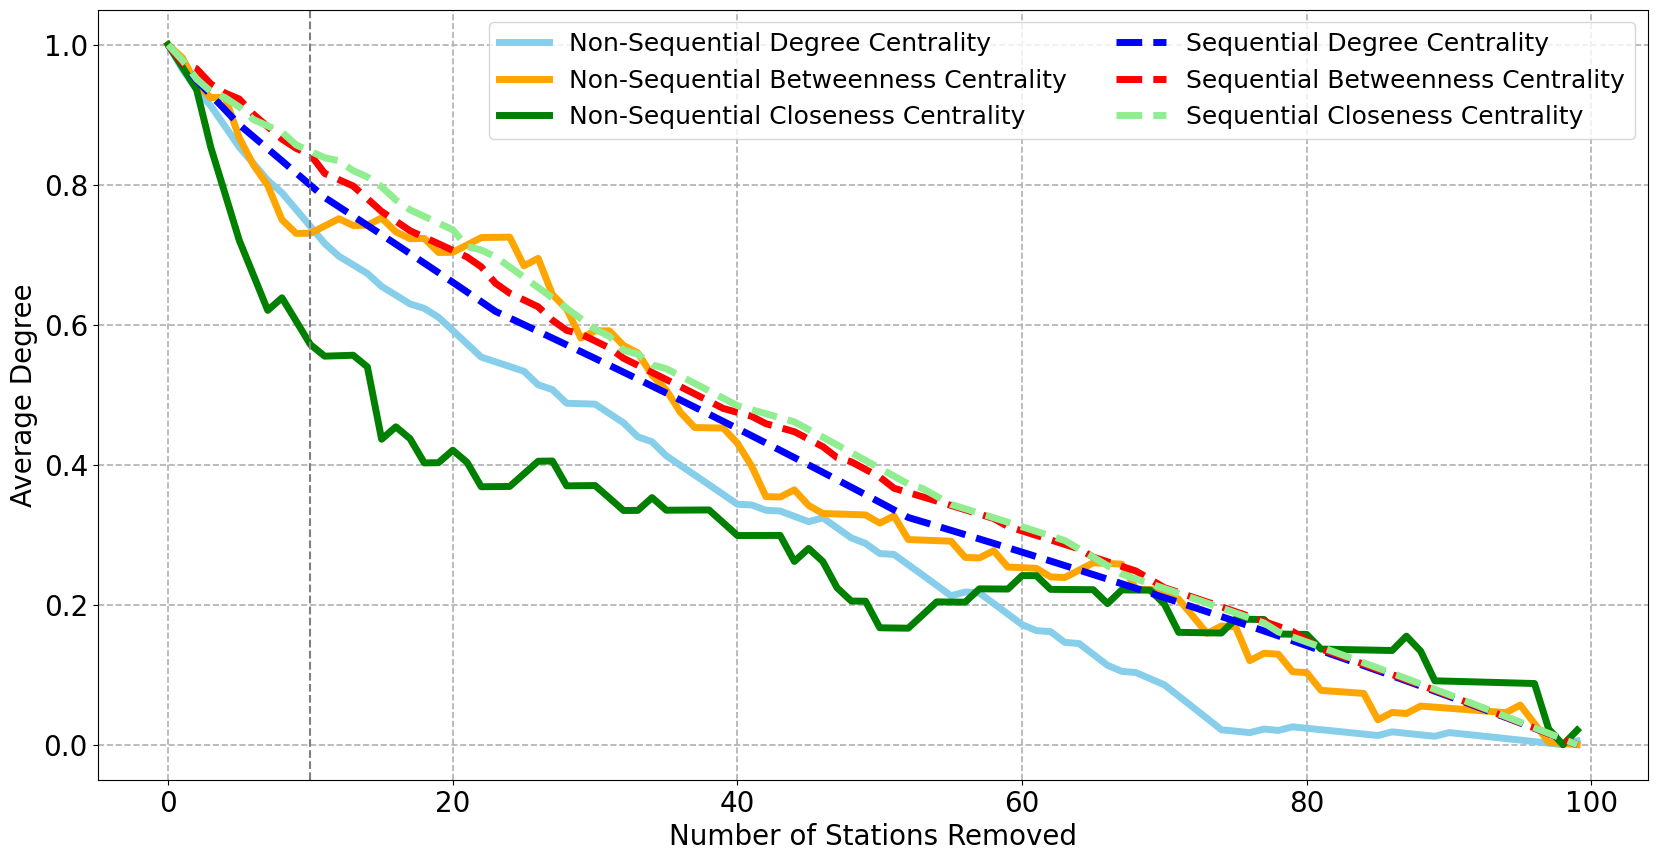

In [33]:
plt.figure(figsize=(20, 10))
plt.plot(range(100), average_dc_nonseq_norm[:100], label='Non-Sequential Degree Centrality', color='skyblue', linestyle='-',linewidth=5,markersize=12)
plt.plot(range(100), average_bc_nonseq_norm[:100], label='Non-Sequential Betweenness Centrality', color='orange', linestyle='-',linewidth=5,markersize=12)
plt.plot(range(100), average_cc_nonseq_norm[:100], label='Non-Sequential Closeness Centrality', color='green', linestyle='-',linewidth=5,markersize=12)
plt.plot(range(100), average_dc_seq_norm[:100], label='Sequential Degree Centrality', color='blue', linestyle='--',linewidth=5,markersize=12)
plt.plot(range(100), average_bc_seq_norm[:100], label='Sequential Betweenness Centrality', color='red', linestyle='--',linewidth=5,markersize=12)
plt.plot(range(100), average_cc_seq_norm[:100], label='Sequential Closeness Centrality', color='lightgreen', linestyle='--',linewidth=5,markersize=12)
plt.xlabel('Number of Stations Removed', fontsize=20)
plt.ylabel('Average Degree', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True, which='both', linestyle='--', linewidth=1.2)
plt.axvline(x=10, color='gray', linestyle='--')
plt.legend(ncol=2,fontsize=18)

plt.savefig('output/average_degree2.png',dpi=300)
plt.show()


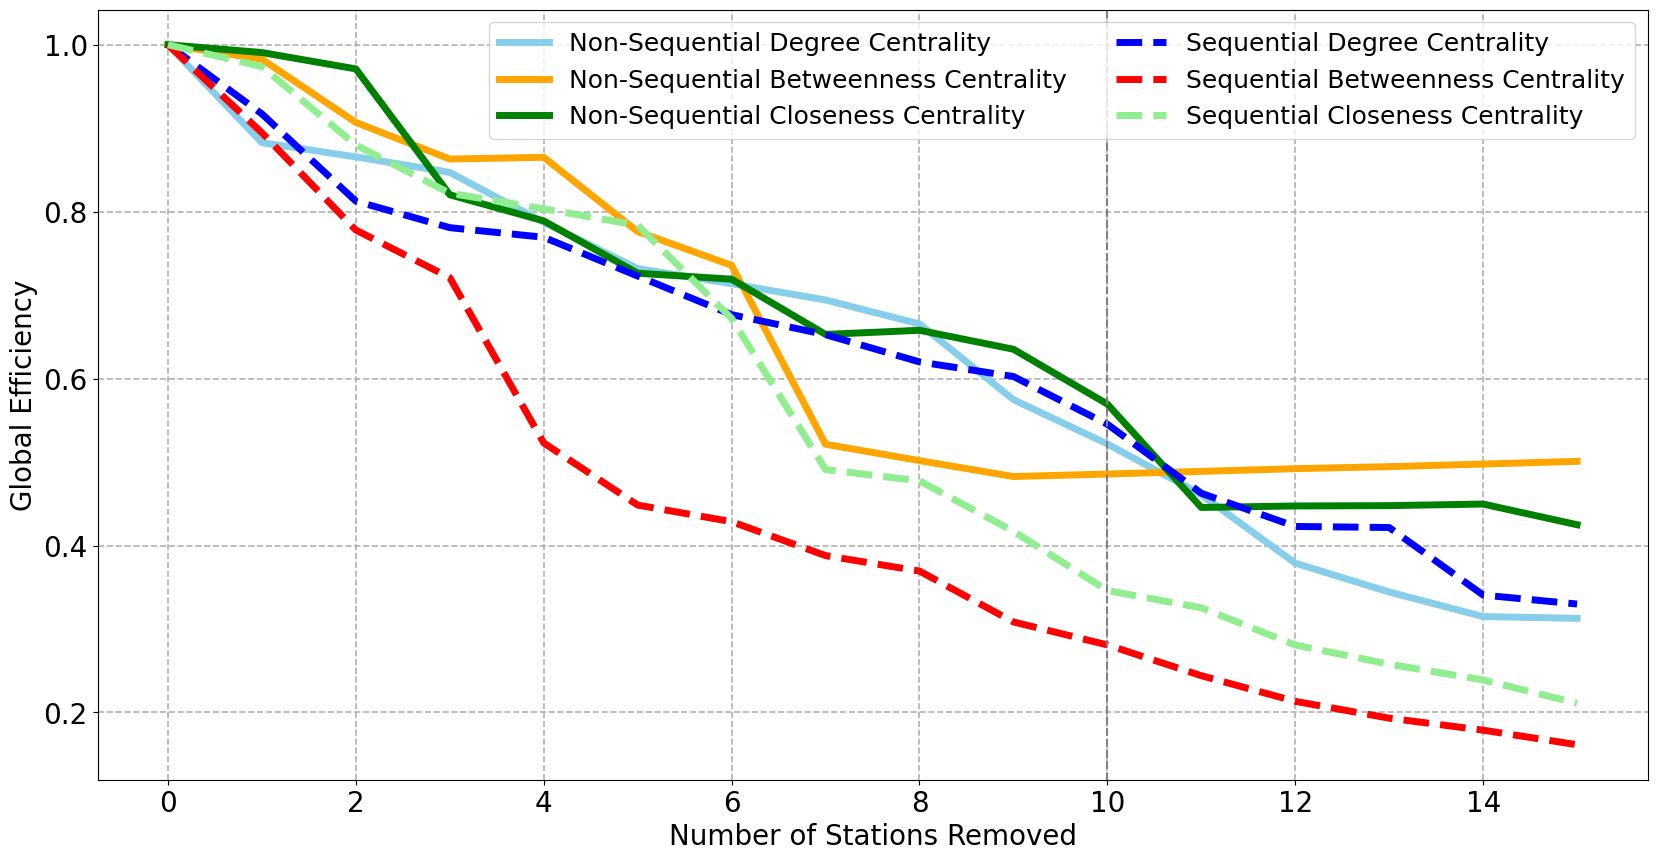

In [34]:
plt.figure(figsize=(20, 10))

plt.plot(range(16), global_dc_nonseq_norm[:16], label='Non-Sequential Degree Centrality', color='skyblue', linestyle='-',linewidth=5,markersize=12)
plt.plot(range(16), global_bc_nonseq_norm[:16], label='Non-Sequential Betweenness Centrality', color='orange', linestyle='-',linewidth=5,markersize=12)
plt.plot(range(16), global_cc_nonseq_norm[:16], label='Non-Sequential Closeness Centrality', color='green', linestyle='-',linewidth=5,markersize=12)
plt.plot(range(16), global_dc_seq_norm[:16], label='Sequential Degree Centrality', color='blue', linestyle='--',linewidth=5,markersize=12)
plt.plot(range(16), global_bc_seq_norm[:16], label='Sequential Betweenness Centrality', color='red', linestyle='--',linewidth=5,markersize=12)
plt.plot(range(16), global_cc_seq_norm[:16], label='Sequential Closeness Centrality', color='lightgreen', linestyle='--',linewidth=5,markersize=12)

plt.xlabel('Number of Stations Removed', fontsize=20)
plt.ylabel('Global Efficiency', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True, which='both', linestyle='--', linewidth=1.2)
plt.axvline(x=10, color='gray', linestyle='--')
plt.legend(ncol=2,fontsize=18)

plt.savefig('output/global_efficiency1.png',dpi=300)
plt.show()


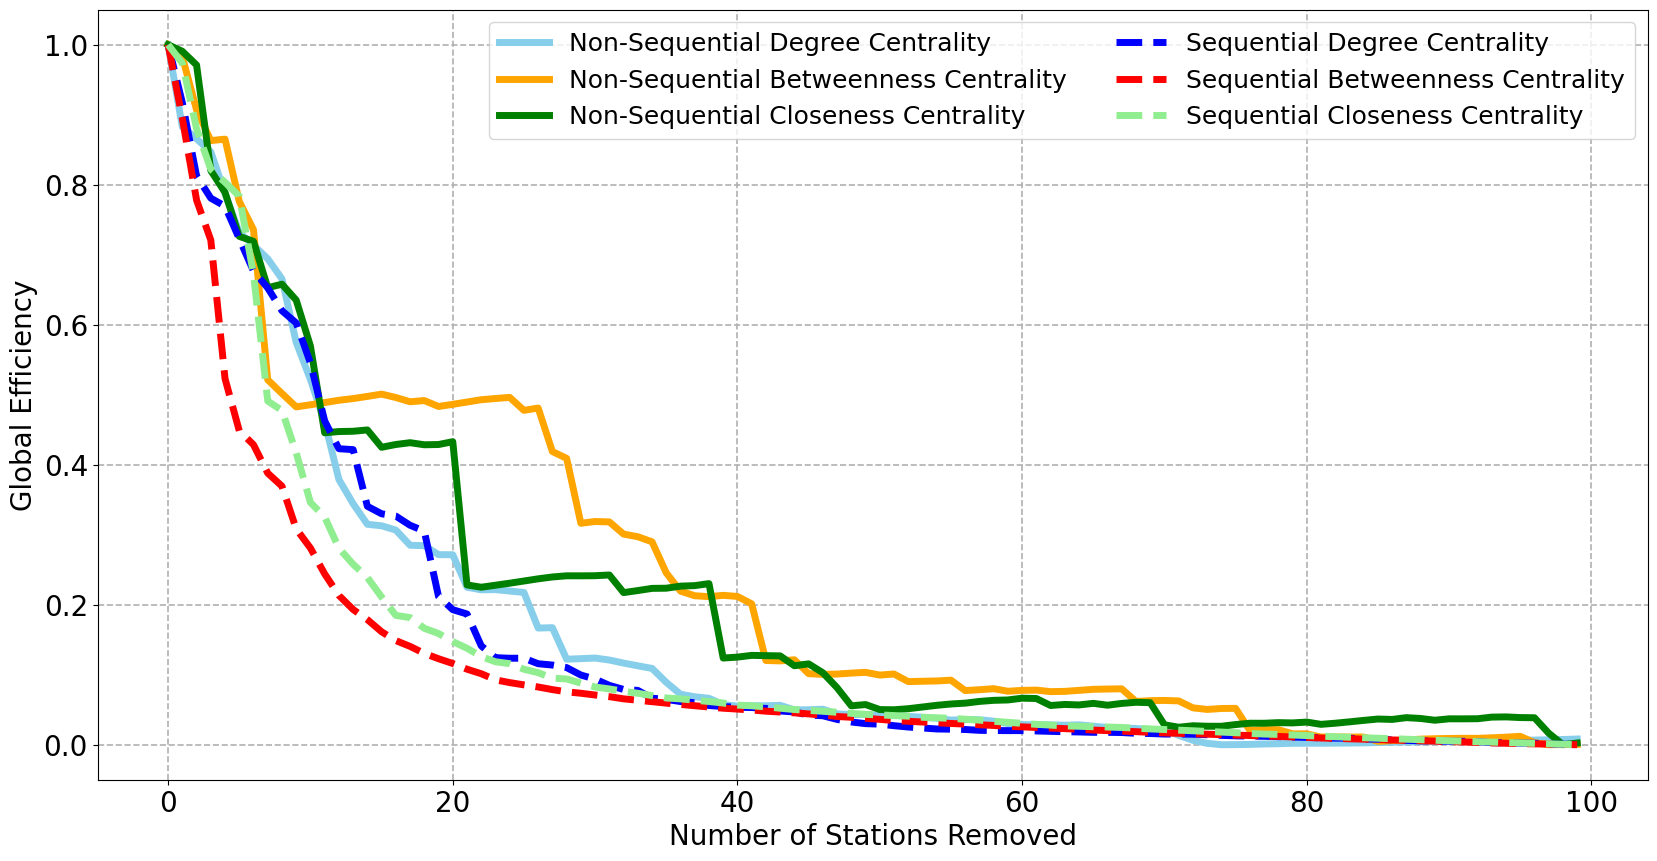

In [35]:
plt.figure(figsize=(20, 10))
plt.plot(range(100), global_dc_nonseq_norm[:100], label='Non-Sequential Degree Centrality', color='skyblue', linestyle='-',linewidth=5,markersize=12)
plt.plot(range(100), global_bc_nonseq_norm[:100], label='Non-Sequential Betweenness Centrality', color='orange', linestyle='-',linewidth=5,markersize=12)
plt.plot(range(100), global_cc_nonseq_norm[:100], label='Non-Sequential Closeness Centrality', color='green', linestyle='-',linewidth=5,markersize=12)
plt.plot(range(100), global_dc_seq_norm[:100], label='Sequential Degree Centrality', color='blue', linestyle='--',linewidth=5,markersize=12)
plt.plot(range(100), global_bc_seq_norm[:100], label='Sequential Betweenness Centrality', color='red', linestyle='--',linewidth=5,markersize=12)
plt.plot(range(100), global_cc_seq_norm[:100], label='Sequential Closeness Centrality', color='lightgreen', linestyle='--',linewidth=5,markersize=12)
plt.xlabel('Number of Stations Removed', fontsize=20)
plt.ylabel('Global Efficiency', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True, which='both', linestyle='--', linewidth=1.2)
plt.legend(ncol=2,fontsize=18)

plt.savefig('output/global_efficiency2.png',dpi=300)
plt.show()

In [36]:
global_dc_nonseq_decrease = ((global_dc_nonseq_norm[0] - global_dc_nonseq_norm[10]) / global_dc_nonseq_norm[0]) * 100
global_cc_nonseq_decrease = ((global_cc_nonseq_norm[0] - global_cc_nonseq_norm[10]) / global_cc_nonseq_norm[0]) * 100
global_bc_nonseq_decrease = ((global_bc_nonseq_norm[0] - global_bc_nonseq_norm[10]) / global_bc_nonseq_norm[0]) * 100
global_dc_seq_decrease = ((global_dc_seq_norm[0] - global_dc_seq_norm[10]) / global_dc_seq_norm[0]) * 100
global_cc_seq_decrease = ((global_cc_seq_norm[0] - global_cc_seq_norm[10]) / global_cc_seq_norm[0]) * 100
global_bc_seq_decrease = ((global_bc_seq_norm[0] - global_bc_seq_norm[10]) / global_bc_seq_norm[0]) * 100

data_global_decrease = {'Centrality Measure': ['Degree(nonseq)', 'Closeness(nonseq)', 'Betweenness(nonseq)', 'Degree (seq)', 'Closeness (seq)', 'Betweenness (seq)'],
                        'Global Efficiency Decrease (%)': [global_dc_nonseq_decrease, global_cc_nonseq_decrease, global_bc_nonseq_decrease,
                                                           global_dc_seq_decrease, global_cc_seq_decrease, global_bc_seq_decrease]}
df_global_decrease = pd.DataFrame(data_global_decrease)
print(df_global_decrease)

    Centrality Measure  Global Efficiency Decrease (%)
0       Degree(nonseq)                       47.831588
1    Closeness(nonseq)                       43.051766
2  Betweenness(nonseq)                       51.435921
3         Degree (seq)                       45.473517
4      Closeness (seq)                       65.397143
5    Betweenness (seq)                       71.908464


In [37]:
average_dc_nonseq_decrease = ((average_dc_nonseq_norm[0] - average_dc_nonseq_norm[10]) / average_dc_nonseq_norm[0]) * 100
average_cc_nonseq_decrease = ((average_cc_nonseq_norm[0] - average_cc_nonseq_norm[10]) / average_cc_nonseq_norm[0]) * 100
average_bc_nonseq_decrease = ((average_bc_nonseq_norm[0] - average_bc_nonseq_norm[10]) / average_bc_nonseq_norm[0]) * 100
average_dc_seq_decrease = ((average_dc_seq_norm[0] - average_dc_seq_norm[10]) / average_dc_seq_norm[0]) * 100
average_cc_seq_decrease = ((average_cc_seq_norm[0] - average_cc_seq_norm[10]) / average_cc_seq_norm[0]) * 100
average_bc_seq_decrease = ((average_bc_seq_norm[0] - average_bc_seq_norm[10]) / average_bc_seq_norm[0]) * 100

data_average_decrease = {'Centrality Measure': ['Degree(nonseq)', 'Closeness(nonseq)', 'Betweenness(nonseq)', 'Degree (seq)', 'Closeness (seq)', 'Betweenness (seq)'],
                        'Average Degree Decrease (%)': [average_dc_nonseq_decrease, average_cc_nonseq_decrease, average_bc_nonseq_decrease,
                                                           average_dc_seq_decrease, average_cc_seq_decrease, average_bc_seq_decrease]}
df_average_decrease = pd.DataFrame(data_average_decrease)
print(df_average_decrease)

    Centrality Measure  Average Degree Decrease (%)
0       Degree(nonseq)                    25.968032
1    Closeness(nonseq)                    42.842507
2  Betweenness(nonseq)                    26.927250
3         Degree (seq)                    20.070931
4      Closeness (seq)                    15.227459
5    Betweenness (seq)                    15.694524


## 2. Flows: weighted network

> Include passengers into the underground, and assess whether different 
measures need to be used when flows are considered. The network to use in this section is the 
weighted network given to you in the coursework, where the flows of passengers were assigned to the 
links between stations

> 14

In [38]:
G = nx.read_graphml('data/london.graph')
london_flow = pd.read_csv('https://raw.githubusercontent.com/yiyansun/urbsim/main/assessment/data/london_flows.csv')
london_flow.head()

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167


### II.1. Old vs new measure
> Consider the centrality measure derived in I. indicating the most relevant stations for assessing 
the vulnerability of the underground. What would you need to do to adjust this measure for a 
weighted network? Recompute the ranking of the 10 most important nodes according to this adjusted 
measure. Do you find the same ones as in I.1?    3


In [39]:
G2 = G.copy()

# Add the flows to the edges
for i, row in london_flow.iterrows():
    origin = row['station_origin']
    destination = row['station_destination']
    flow = row['flows']
    
    if G2.has_edge(origin, destination):
        G2[origin][destination]['flows_inv'] = 1 / ( flow + .0001)

In [40]:
# weighted betweenness centrality
bet_w=nx.betweenness_centrality(G2,normalized=True, weight='flows_inv')
nx.set_node_attributes(G2,bet_w,'betweenness_w')
df_w = pd.DataFrame(index=G2.nodes())
df_w['station_name_w'] = pd.Series(nx.get_node_attributes(G2, 'station_name'))
df_w['betweenness_w'] = pd.Series(nx.get_node_attributes(G2, 'betweenness_w'))

df_sorted_w = df_w.sort_values(["betweenness_w"], ascending=False)
betweenness_centrality_w = df_sorted_w[0:10]
betweenness_centrality_w

,station_name_w,betweenness_w
Bank and Monument,NaN,0.524825
Stratford,NaN,0.448509
Liverpool Street,NaN,0.398070
West Ham,NaN,0.351742
King's Cross St. Pancras,NaN,0.345840
Green Park,NaN,0.308897
Waterloo,NaN,0.297531
Canning Town,NaN,0.277268
Westminster,NaN,0.273170
Moorgate,NaN,0.271867


In [41]:
# unweighted betweenness centrality
bet_t=nx.betweenness_centrality(G,normalized=True,weight='length')

# add these values to the nodes attributes:
nx.set_node_attributes(G,bet_t,'betweenness')
# To dataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())
df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df['betweenness'] = pd.Series(nx.get_node_attributes(G, 'betweenness'))

df_sorted = df.sort_values(["betweenness"], ascending=False)
betweenness_centrality = df_sorted[0:10]
betweenness_centrality

,station_name,betweenness
Bank and Monument,NaN,0.221253
King's Cross St. Pancras,NaN,0.209185
Stratford,NaN,0.182306
Oxford Circus,NaN,0.169937
Euston,NaN,0.165915
Baker Street,NaN,0.152256
Earl's Court,NaN,0.143797
Shadwell,NaN,0.139449
Waterloo,NaN,0.130426
South Kensington,NaN,0.129511


In [42]:
top_stations_bc_flows = pd.concat([betweenness_centrality.reset_index(drop=True),
                                 betweenness_centrality_w.reset_index(drop=True)], axis=1)

top_stations_bc_flows.insert(0, 'Rank', range(1, 11))

top_stations_bc_flows

,Rank,station_name,betweenness,station_name_w,betweenness_w
0,1,NaN,0.221253,NaN,0.524825
1,2,NaN,0.209185,NaN,0.448509
2,3,NaN,0.182306,NaN,0.398070
3,4,NaN,0.169937,NaN,0.351742
4,5,NaN,0.165915,NaN,0.345840
5,6,NaN,0.152256,NaN,0.308897
6,7,NaN,0.143797,NaN,0.297531
7,8,NaN,0.139449,NaN,0.277268
8,9,NaN,0.130426,NaN,0.273170
9,10,NaN,0.129511,NaN,0.271867


KeyError: 'Wembley Park'

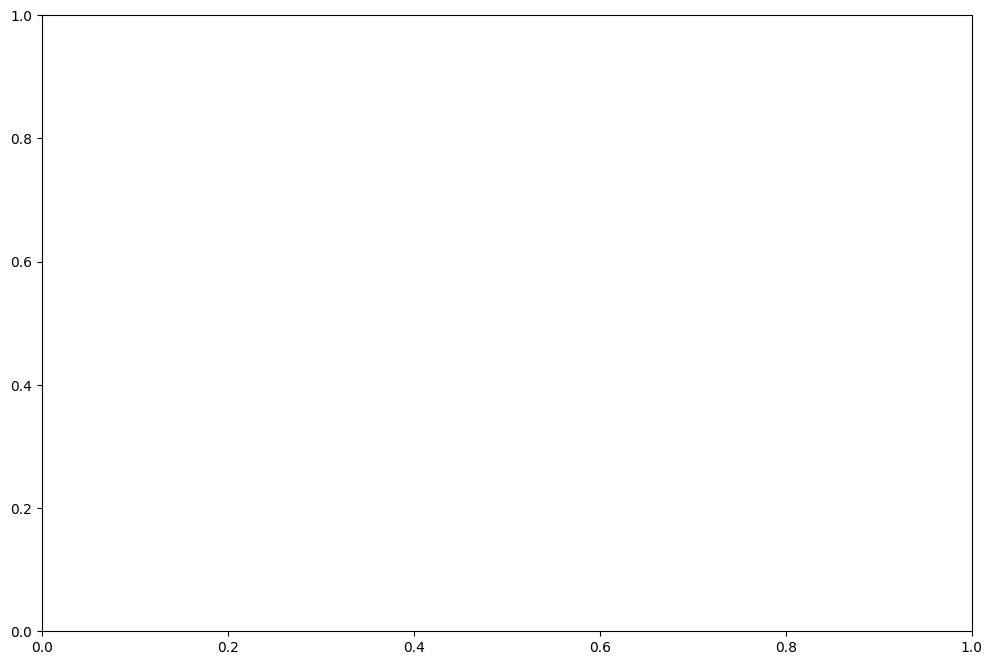

In [43]:
betweenness_f_values=[(i[1]['betweenness_w']) for i in G2.nodes(data=True)]

bet_w_color=[(i[1]['betweenness_w']/max(betweenness_f_values)) for i in G2.nodes(data=True)]
bet_w_size=[(i[1]['betweenness_w']/max(betweenness_f_values))*100 for i in G2.nodes(data=True)]

pos=pos
fig, ax = plt.subplots(figsize=(12,8))
nx.draw_networkx_edges(G2, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(G2,
        pos = pos,
        node_color= bet_w_color,
        node_size= bet_w_size)
plt.colorbar(nod,label="Betweenness Centrality",orientation="vertical", shrink=0.5)
plt.axis("off")
plt.title("Underground Betweenness Centrality",fontsize=15)
plt.savefig("output/betweenness_centrality_flows.png", format="PNG")
plt.show()

In [45]:
G_un=G.to_undirected()
new_weight = {}

for e1, e2, c in G_un.edges(data='flows'):
    if c is None or c == 0:
        new_weight[(e1, e2)] = 0
    else:
        new_weight[(e1, e2)] = 1 / c

nx.set_edge_attributes(G_un, new_weight, 'new_weight')

nx.to_pandas_edgelist(G_un)

,source,target,line_name,new_weight,flows,length
0,Wembley Park,Kingsbury,Jubilee,0.000081,12356,2916.771558
1,Wembley Park,Neasden,Jubilee,0.000148,6744,2353.165938
2,Wembley Park,Preston Road,Metropolitan,0.000027,36601,1419.735166
3,Wembley Park,Finchley Road,Metropolitan,0.000018,55216,7266.373927
4,Kingsbury,Queensbury,Jubilee,0.000106,9419,1245.995234
...,...,...,...,...,...,...
462,Hounslow Central,Hounslow East,Piccadilly,0.000074,13469,745.684383
463,Hounslow East,Osterley,Piccadilly,0.000063,15935,967.494672
464,Osterley,Boston Manor,Piccadilly,0.000057,17445,2560.814291
465,Boston Manor,Northfields,Piccadilly,0.000054,18598,930.852145


In [46]:
degree_centrality_w = pd.DataFrame(nx.degree(G_un,weight='new_weight'), columns=['degree_w(nonseq)', 'value']) \
                      .sort_values(by='value', ascending=False) \
                      .iloc[:10]
degree_centrality_w

,degree_w(nonseq),value
363,Lambeth North,0.011066
315,Elephant & Castle,0.010761
264,Abbey Road,0.004579
87,Theobalds Grove,0.004555
387,Heathrow Terminal 4,0.004063
389,Heathrow Terminals 2 & 3,0.003916
263,Stratford High Street,0.003589
88,Cheshunt,0.003484
265,Star Lane,0.003176
6,West Ham,0.002919


In [47]:
closeness_centrality_w = pd.DataFrame.from_dict(nx.closeness_centrality(G_un, distance='new_weight'), 
                                               orient='index', columns=['value']) \
                         .rename_axis('closeness_w(nonseq)').reset_index() \
                         .sort_values(by='value', ascending=False) \
                         .iloc[:10]
closeness_centrality_w

,closeness_w(nonseq),value
16,Green Park,2377.569519
15,Westminster,2372.542016
14,Waterloo,2367.998823
50,Bank and Monument,2364.577066
45,Oxford Circus,2355.796242
17,Bond Street,2352.780789
204,Victoria,2345.842679
51,Liverpool Street,2345.155626
341,Warren Street,2329.989523
232,Moorgate,2325.095146


In [48]:
betweenness_centrality_w = pd.DataFrame.from_dict(nx.betweenness_centrality(G_un, weight='new_weight'), 
                                                 orient='index', columns=['value']) \
                            .rename_axis('betweenness_w(nonseq)').reset_index() \
                            .sort_values(by='value', ascending=False) \
                            .iloc[:10]
betweenness_centrality_w

,betweenness_w(nonseq),value
16,Green Park,0.562563
50,Bank and Monument,0.498227
14,Waterloo,0.399803
15,Westminster,0.371736
51,Liverpool Street,0.332456
5,Stratford,0.327381
17,Bond Street,0.288177
150,Euston,0.279624
45,Oxford Circus,0.265752
341,Warren Street,0.249574


In [49]:
top_stations_w_nonseq = pd.concat([degree_centrality_w.reset_index(drop=True),
                          closeness_centrality_w.reset_index(drop=True),
                          betweenness_centrality_w.reset_index(drop=True)], axis=1)

top_stations_w_nonseq .insert(0,'Rank',range(1,11))

top_stations_w_nonseq

,Rank,degree_w(nonseq),value,closeness_w(nonseq),value,betweenness_w(nonseq),value
0,1,Lambeth North,0.011066,Green Park,2377.569519,Green Park,0.562563
1,2,Elephant & Castle,0.010761,Westminster,2372.542016,Bank and Monument,0.498227
2,3,Abbey Road,0.004579,Waterloo,2367.998823,Waterloo,0.399803
3,4,Theobalds Grove,0.004555,Bank and Monument,2364.577066,Westminster,0.371736
4,5,Heathrow Terminal 4,0.004063,Oxford Circus,2355.796242,Liverpool Street,0.332456
5,6,Heathrow Terminals 2 & 3,0.003916,Bond Street,2352.780789,Stratford,0.327381
6,7,Stratford High Street,0.003589,Victoria,2345.842679,Bond Street,0.288177
7,8,Cheshunt,0.003484,Liverpool Street,2345.155626,Euston,0.279624
8,9,Star Lane,0.003176,Warren Street,2329.989523,Oxford Circus,0.265752
9,10,West Ham,0.002919,Moorgate,2325.095146,Warren Street,0.249574


In [50]:
degree_centrality_w_seq=[]
G_dc_w_seq=G_un.copy()
for i in range(0,10):
    degree=nx.degree(G_dc_w_seq,weight='new_weight')
    nx.set_node_attributes(G_dc_w_seq,dict(degree),'degree')
    degree_df=pd.DataFrame.from_dict(dict(degree),columns=['degree'],orient='index')
    node6=list(degree_df.sort_values('degree',axis = 0,ascending = False).index)
    degree_centrality_w_seq.append(node6[0])
    G_dc_w_seq.remove_nodes_from([node6[0]])

degree_centrality_w_seq

['Lambeth North',
 'Abbey Road',
 'Theobalds Grove',
 'Heathrow Terminal 4',
 'Star Lane',
 'Grange Hill',
 'Chalfont & Latimer',
 'Tower Hill',
 'Emerson Park',
 'Chiswick Park']

In [51]:
closeness_centrality_w_seq=[]
G_cc_w_seq=G_un.copy()
for i in range(0,10):
    closeness_w_seq=nx.closeness_centrality(G_cc_w_seq, distance = 'new_weight')
    nx.set_node_attributes(G_cc_w_seq,closeness_w_seq,'closeness')
    closeness_df=pd.DataFrame.from_dict(closeness_w_seq,columns=['closeness'],orient='index')
    node5=list(closeness_df.sort_values('closeness',axis = 0,ascending = False).index)
    closeness_centrality_w_seq.append(node5[0])
    G_cc_w_seq.remove_nodes_from([node5[0]])
    
closeness_centrality_w_seq

['Green Park',
 'Bank and Monument',
 "King's Cross St. Pancras",
 'Waterloo',
 'Stockwell',
 'West Brompton',
 'Highbury & Islington',
 'Blackhorse Road',
 'Bond Street',
 'Notting Hill Gate']

In [52]:
betweeness_centrality_w_seq=[]
G_bc_w_seq=G_un.copy()

for i in range(0,10):
    # recalculate the centrality values and remove the most largest one
    betweeness_w_seq=nx.betweenness_centrality(G_bc_w_seq, weight='new_weight',normalized=False)
    nx.set_node_attributes(G_bc_w_seq,betweeness_w_seq,'betweenness')
    betweenness_df=pd.DataFrame.from_dict(betweeness_w_seq,columns=['betweenness'],orient='index')
    node4=list(betweenness_df.sort_values('betweenness',axis = 0,ascending = False).index)
    betweeness_centrality_w_seq.append(node4[0])
    G_bc_w_seq.remove_nodes_from([node4[0]])
    
betweeness_centrality_w_seq

['Green Park',
 'Bank and Monument',
 "King's Cross St. Pancras",
 'Canada Water',
 'Finchley Road',
 'Highbury & Islington',
 'Blackhorse Road',
 "Earl's Court",
 'Willesden Junction',
 "Shepherd's Bush"]

In [53]:
top_stations_w_seq= pd.DataFrame({'degree_w(seq)': degree_centrality_w_seq, 'closeness_w(seq)': closeness_centrality_w_seq, 'betweeness_w(seq)': betweeness_centrality_w_seq})
top_stations_w_seq .insert(0,'Rank',range(1,11))
top_stations_w_seq

,Rank,degree_w(seq),closeness_w(seq),betweeness_w(seq)
0,1,Lambeth North,Green Park,Green Park
1,2,Abbey Road,Bank and Monument,Bank and Monument
2,3,Theobalds Grove,King's Cross St. Pancras,King's Cross St. Pancras
3,4,Heathrow Terminal 4,Waterloo,Canada Water
4,5,Star Lane,Stockwell,Finchley Road
5,6,Grange Hill,West Brompton,Highbury & Islington
6,7,Chalfont & Latimer,Highbury & Islington,Blackhorse Road
7,8,Tower Hill,Blackhorse Road,Earl's Court
8,9,Emerson Park,Bond Street,Willesden Junction
9,10,Chiswick Park,Notting Hill Gate,Shepherd's Bush


In [54]:
# Calculate the global efficiency of Graph
def my_global_efficiency_w(Graph):
    n = len(Graph)
    denom = n * (n - 1)
    if denom != 0:
        lengths = nx.all_pairs_dijkstra_path_length(Graph, weight = 'new_weight')
        g_eff = 0
        for source, targets in lengths:
            for target, distance in targets.items():
                if distance > 0:
                    g_eff += 1 / distance
        g_eff /= denom
    else:
        g_eff = 0
        
    return g_eff

In [55]:
# betweenness non-seq
bet_london_w=nx.betweenness_centrality(G_un,weight='new_weight', normalized=False)
betweenness_df=pd.DataFrame.from_dict(bet_london_w,columns=['betweenness_w'],orient='index')
node1=list(betweenness_df.sort_values('betweenness_w',axis = 0,ascending = False).index)
score_b_1=[]
scoreG_b_1=[]
g_1=G_un.copy()
for i in range(0,len(list(G_un.nodes))):
    score_b_1.append(calculate_average_degree(g_1))
    scoreG_b_1.append(my_global_efficiency_w(g_1))
    g_1.remove_nodes_from([node1[i]])
    
# closeness non-seq
closeness_w=nx.closeness_centrality(G_un,distance='new_weight')
closeness_df=pd.DataFrame.from_dict(closeness_w,columns=['closeness_w'],orient='index')
node2=list(closeness_df.sort_values('closeness_w',axis = 0,ascending = False).index)
score_b_2=[]
scoreG_b_2=[]
g_2=G_un.copy()
for i in range(0,len(list(G_un.nodes))):
    score_b_2.append(calculate_average_degree(g_2))
    scoreG_b_2.append(my_global_efficiency_w(g_2))
    g_2.remove_nodes_from([node2[i]])

# degree non-seq
degree=G_un.degree(weight='new_weight')
degree_df=pd.DataFrame.from_dict(dict(degree),columns=['degree'],orient='index')
node3=list(degree_df.sort_values('degree',axis = 0,ascending = False).index)
score_b_3=[]
scoreG_b_3=[]
g_3=G_un.copy()
for i in range(0,len(list(G_un.nodes))):
    score_b_3.append(calculate_average_degree(g_3))
    scoreG_b_3.append(my_global_efficiency_w(g_3))    
    g_3.remove_nodes_from([node3[i]])

#betweenness seq
score_b_4=[]
scoreG_b_4=[]
g_4=G_un.copy()
for i in range(0,len(list(G_un.nodes))):
    score_b_4.append(calculate_average_degree(g_4))
    scoreG_b_4.append(my_global_efficiency_w(g_4)) 
    bet_london_w=nx.betweenness_centrality(g_4, weight='new_weight',normalized=False)
    nx.set_node_attributes(g_4,bet_london_w,'betweenness_w')
    betweenness_df=pd.DataFrame.from_dict(bet_london_w,columns=['betweenness_w'],orient='index')
    node4=list(betweenness_df.sort_values('betweenness_w',axis = 0,ascending = False).index)
    g_4.remove_nodes_from([node4[0]])

# closeness seq
score_b_5=[]
scoreG_b_5=[]
g_5=G_un.copy()
for i in range(0,len(list(G_un.nodes))):
    score_b_5.append(calculate_average_degree(g_5))
    scoreG_b_5.append(my_global_efficiency_w(g_5))     
    closeness_w=nx.closeness_centrality(g_5,distance='new_weight')
    nx.set_node_attributes(g_5,closeness_w,'closeness_w')
    closeness_df=pd.DataFrame.from_dict(closeness_w,columns=['closeness_w'],orient='index')
    node5=list(closeness_df.sort_values('closeness_w',axis = 0,ascending = False).index)
    g_5.remove_nodes_from([node5[0]])
    
# degree seq
score_b_6=[]
scoreG_b_6=[]
g_6=G_un.copy()
for i in range(0,len(list(G_un.nodes))):
    score_b_6.append(calculate_average_degree(g_6))
    scoreG_b_6.append(my_global_efficiency_w(g_6))    
    degree=g_6.degree(weight='new_weight')
    nx.set_node_attributes(g_6,dict(degree),'degree')
    degree_df=pd.DataFrame.from_dict(dict(degree),columns=['degree'],orient='index')
    node6=list(degree_df.sort_values('degree',axis = 0,ascending = False).index)
    g_6.remove_nodes_from([node6[0]])

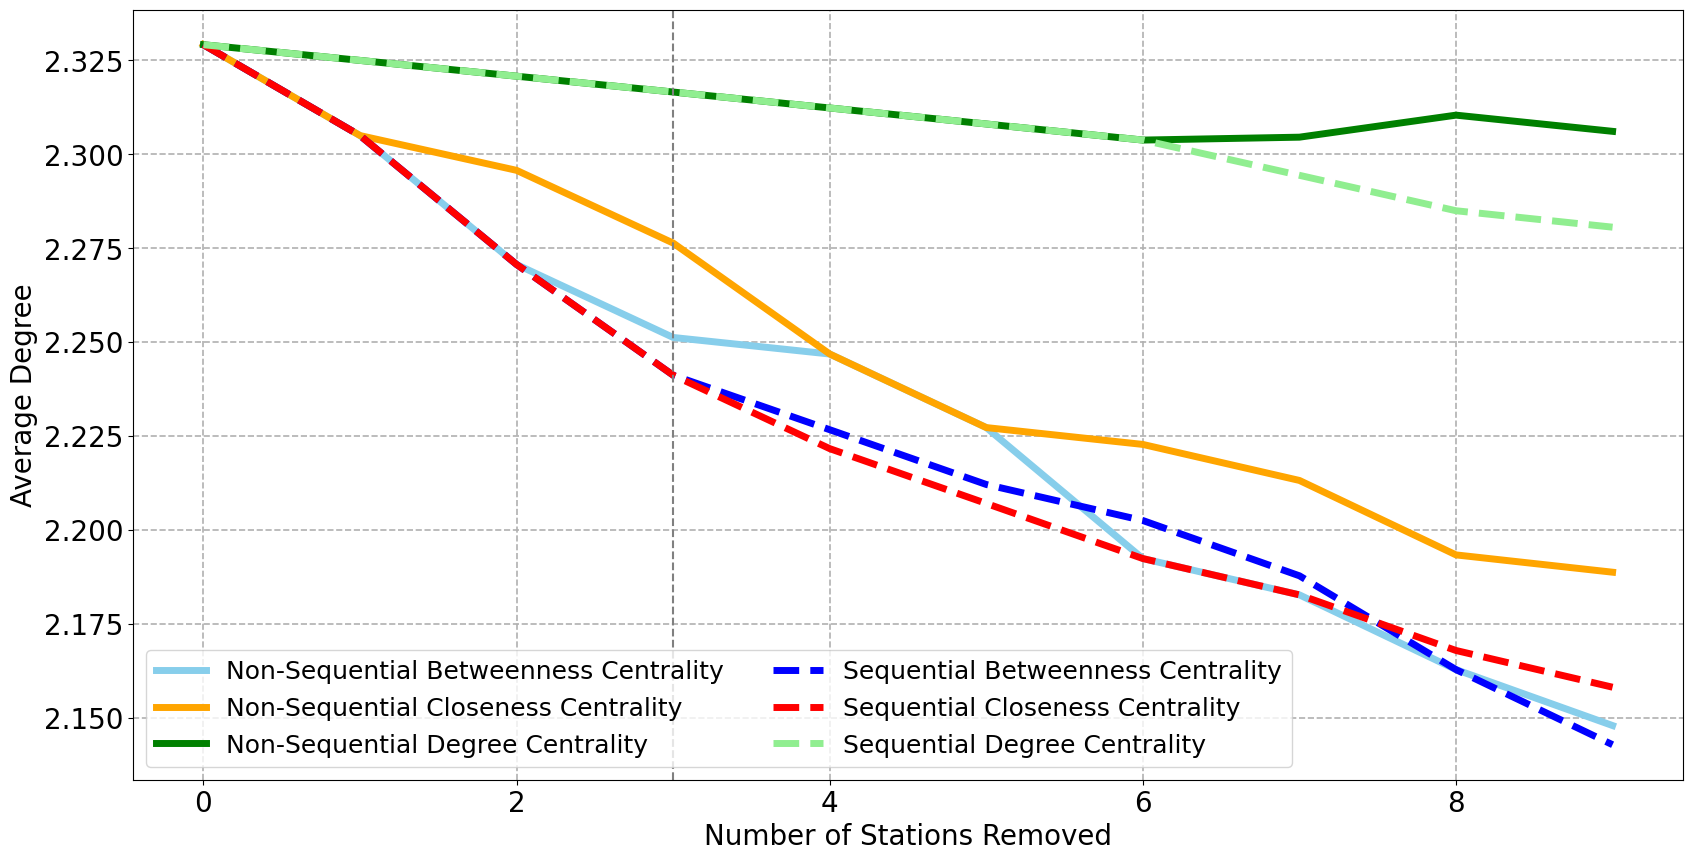

In [56]:
# plot
plt.figure(figsize=(20, 10))
plt.plot(range(10), score_b_1[:10], label='Non-Sequential Betweenness Centrality', color='skyblue', linestyle='-',linewidth=5,markersize=12)
plt.plot(range(10), score_b_2[:10], label='Non-Sequential Closeness Centrality', color='orange', linestyle='-',linewidth=5,markersize=12)
plt.plot(range(10), score_b_3[:10], label='Non-Sequential Degree Centrality', color='green', linestyle='-',linewidth=5,markersize=12)
plt.plot(range(10), score_b_4[:10], label='Sequential Betweenness Centrality', color='blue', linestyle='--',linewidth=5,markersize=12)
plt.plot(range(10), score_b_5[:10], label='Sequential Closeness Centrality', color='red', linestyle='--',linewidth=5,markersize=12)
plt.plot(range(10), score_b_6[:10], label='Sequential Degree Centrality', color='lightgreen', linestyle='--',linewidth=5,markersize=12)
plt.xlabel('Number of Stations Removed', fontsize=20)
plt.ylabel('Average Degree', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.grid(True, which='both', linestyle='--', linewidth=1.2)
plt.axvline(x=3, color='gray', linestyle='--')
plt.legend(ncol=2,fontsize=18)

plt.savefig('output/average_degree_flows1.png',dpi=300)
plt.show()

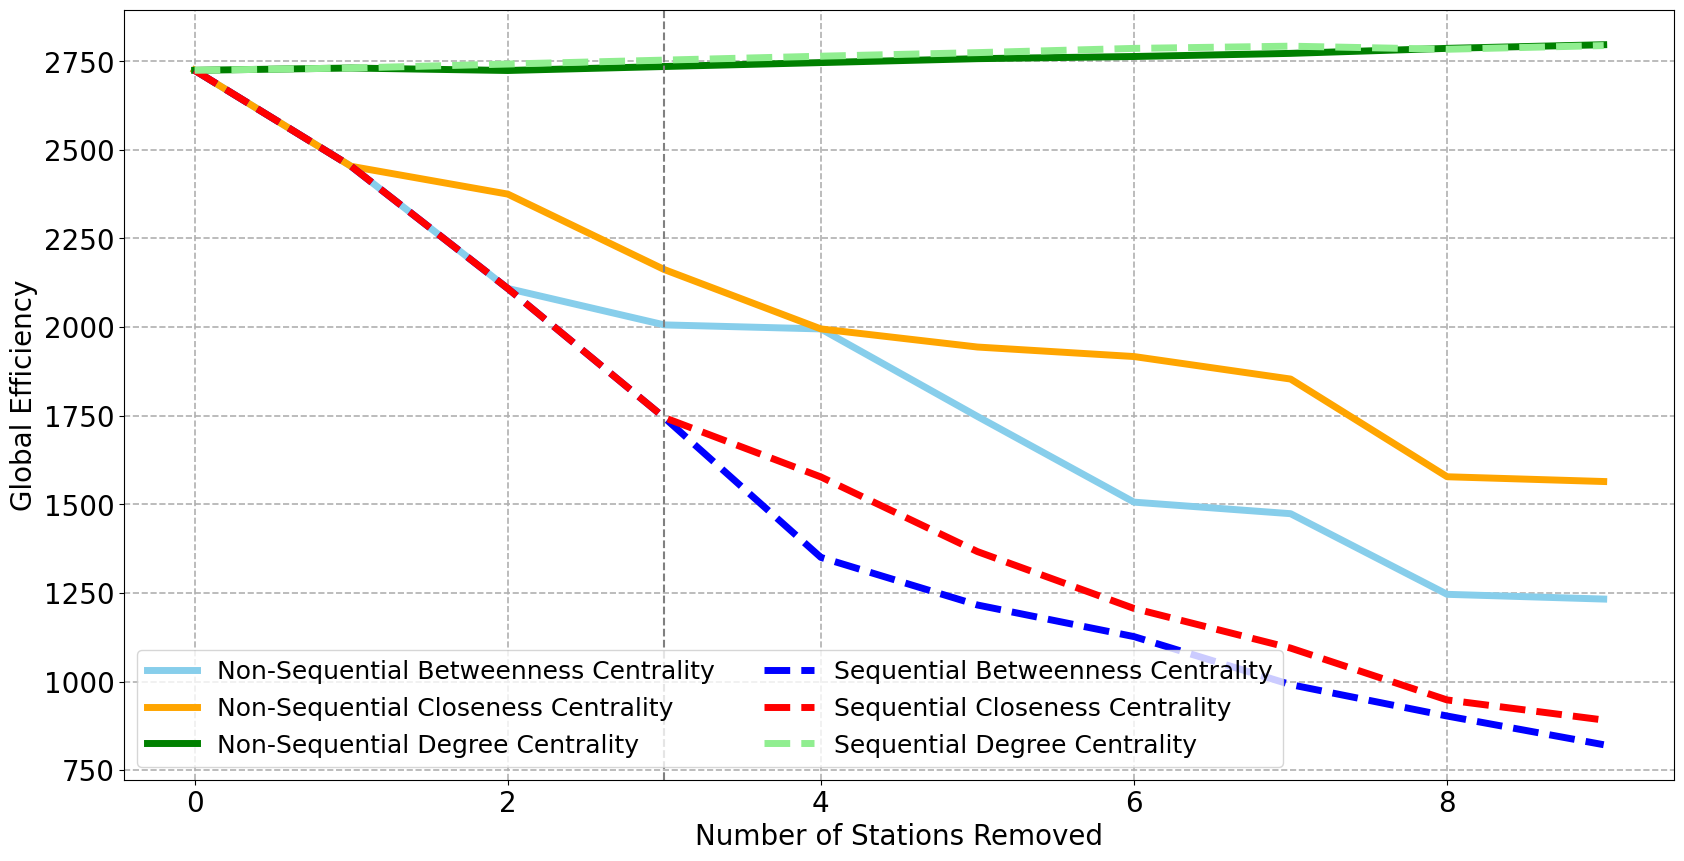

In [57]:
# plot
plt.figure(figsize=(20, 10))
plt.plot(range(10), scoreG_b_1[:10], label='Non-Sequential Betweenness Centrality', color='skyblue', linestyle='-',linewidth=5,markersize=12)
plt.plot(range(10), scoreG_b_2[:10], label='Non-Sequential Closeness Centrality', color='orange', linestyle='-',linewidth=5,markersize=12)
plt.plot(range(10), scoreG_b_3[:10], label='Non-Sequential Degree Centrality', color='green', linestyle='-',linewidth=5,markersize=12)
plt.plot(range(10), scoreG_b_4[:10], label='Sequential Betweenness Centrality', color='blue', linestyle='--',linewidth=5,markersize=12)
plt.plot(range(10), scoreG_b_5[:10], label='Sequential Closeness Centrality', color='red', linestyle='--',linewidth=5,markersize=12)
plt.plot(range(10), scoreG_b_6[:10], label='Sequential Degree Centrality', color='lightgreen', linestyle='--',linewidth=5,markersize=12)
plt.xlabel('Number of Stations Removed', fontsize=20)
plt.ylabel('Global Efficiency', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True, which='both', linestyle='--', linewidth=1.2)
plt.axvline(x=3, color='gray', linestyle='--')
plt.legend(ncol=2,fontsize=18)

plt.savefig('output/global_efficiency_flows1.png',dpi=300)
plt.show()